In [1]:
//#pragma include_alias("/local/vtk-m/clang/include/vtkm-1.2/vtkm/thirdparty/taotuple/vtkmtaotuple/","vtkmtaotuple")
#include <lodepng_config_cling.h>
#pragma cling add_include_path("/home/ybk/local/vtk-m-1.3.0/include/vtkm-1.3")
#pragma cling add_include_path("/home/ybk/Projects/vtkm-uflic/")
#pragma cling add_library_path("/home/ybk/local/vtk-m-1.3.0/lib/")
#pragma cling load("vtkm_cont-1.3")
#pragma cling load("vtkm_rendering-1.3")
#pragma cling load("omp")

In [2]:
#include <vtkm/cont/DeviceAdapter.h>
#include <vtkm/cont/testing/MakeTestDataSet.h>
#include <vtkm/cont/testing/Testing.h>
#include <vtkm/rendering/Actor.h>
#include <vtkm/rendering/Mapper.h>
#include <vtkm/rendering/Scene.h>
#include <vtkm/rendering/View3D.h>
#include <vtkm/cont/ColorTable.h>
#include <vtkm/rendering/testing/RenderTest.h>
#include <vtkm/io/reader/VTKDataSetReader.h>
#include <vtkm/cont/internal/IteratorFromArrayPortal.h>
#include <vtkm/cont/ArrayPortalToIterators.h>
#include <vtkm/cont/DynamicArrayHandle.h>
#include <vtkm/cont/ArrayCopy.h>
#include <vtkm/worklet/Normalize.h>
#include <vtkm/worklet/DispatcherMapField.h>

#include "Reader.h"
#include "UFLIC.h"
#include "ViewUFLIC.h"
#include "CanvasUFLIC.h"
#include "MapperUFLIC.h"
#include "ReaderUFLIC.h"

Use lodepng to save out png instead of pnm so jupyter can read it.


In [3]:
#include <lodepng.h>
template<typename TupleType>
void convertBuffer(std::vector<std::uint8_t> &PngBuffer,
              int width,
              int height,
              int xIndex,
              int yIndex,
              TupleType &tuple
             );
template<>
void convertBuffer(std::vector<std::uint8_t> &PngBuffer,
              int width,
              int height,
              int xIndex,
              int yIndex,
              vtkm::Int32 &tuple
             )
{
            std::size_t NewPos = (height - yIndex - 1) * (width * 4) + 4 * xIndex;
        PngBuffer[NewPos + 0] = (unsigned char)(tuple);
        PngBuffer[NewPos + 1] = (unsigned char)(tuple);
        PngBuffer[NewPos + 2] = (unsigned char)(tuple);
        PngBuffer[NewPos + 3] = 255;            

}

template<>
void convertBuffer(std::vector<std::uint8_t> &PngBuffer,
              int width,
              int height,
              int xIndex,
              int yIndex,
              vtkm::Vec<vtkm::Float32, 4> &tuple
             )
{
            std::size_t NewPos = (height - yIndex - 1) * (width * 4) + 4 * xIndex;
        PngBuffer[NewPos + 0] = (unsigned char)(tuple[0] * 255);
        PngBuffer[NewPos + 1] = (unsigned char)(tuple[1] * 255);
        PngBuffer[NewPos + 2] = (unsigned char)(tuple[2] * 255);
        PngBuffer[NewPos + 3] = 255;            

}

template<typename ArrayType>
void convertPng(ArrayType &array,int width,int height, std::vector<std::uint8_t> &ImageBuffer)
{    
  std::vector<std::uint8_t> PngBuffer(width*height*4);

  for (vtkm::Id yIndex = 0; yIndex < height; yIndex++)
  {
    for (vtkm::Id xIndex = 0; xIndex < width; xIndex++)
    {
      auto tuple = array.GetPortalConstControl().Get(yIndex * width + xIndex);
      //of << (unsigned char)(tuple[0] * 255);
      //of << (unsigned char)(tuple[1] * 255);
      //of << (unsigned char)(tuple[2] * 255);
        
        convertBuffer(PngBuffer, width, height, xIndex, yIndex, tuple);
    }
  }
  lodepng::encode(ImageBuffer, PngBuffer, width, height);
  return ImageBuffer;
}



template<typename CanvasType>
auto convertPng(CanvasType &canvas)
{
    int width = canvas.GetWidth();
    int height = canvas.GetHeight();

  using ColorBufferType = vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 4>>;

  auto colorArray = canvas.GetColorBuffer();
    std::vector<std::uint8_t> ImageBuffer;
  convertPng(colorArray, width, height, ImageBuffer);
    return ImageBuffer;


}




In [4]:
#include <string>
#include <fstream>

#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"

namespace im
{
    struct image
    {
        inline image(){}
        inline image(const std::vector<uint8_t> &png)
        {
            m_buffer.assign(png.begin(), png.end());
        }

        std::string m_buffer;
    };

    nlohmann::json mime_bundle_repr(const image& i)
    {
        auto bundle = nlohmann::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer);
        return bundle;
    }
}

std::unique_ptr<im::image> displayImage = std::unique_ptr<im::image>();


The default vtkm::rendering::View3D render both world space annotations (think bounding measuring box) and screen space annotations (think color bar). For screen space line integral convolution, we need to remove those.

In [5]:
inline void SetCamera(std::unique_ptr<vtkm::rendering::Camera>& camera,
                      const vtkm::Bounds& coordBounds)
{
  camera = std::unique_ptr<vtkm::rendering::Camera>(new vtkm::rendering::Camera());
  camera->ResetToBounds(coordBounds);
  camera->Azimuth(static_cast<vtkm::Float32>(45.0));
  camera->Elevation(static_cast<vtkm::Float32>(45.0));
}



In [6]:
void Render(ViewUFLIC& view)
{
  view.Initialize();
  view.Paint();
}


In [7]:
inline vtkm::cont::DataSet readVTKDataSet(const char* fname)
{
  vtkm::cont::DataSet ds;
  vtkm::io::reader::VTKDataSetReader reader(fname);
  try
  {
    ds = reader.ReadDataSet();
  }
  catch (vtkm::io::ErrorIO& e)
  {
    std::string message("Error reading: ");
    message += fname;
    message += ", ";
    message += e.GetMessage();

    VTKM_TEST_FAIL(message.c_str());
  }

  return ds;
}

In [8]:
void addField(vtkm::cont::DataSet &ds){
    auto cnt = ds.GetField(0).GetData().GetNumberOfValues();
    vtkm::cont::DataSetFieldAdd dsf;
    std::vector<vtkm::Float32> vars(cnt);
    for (int i=0; i<cnt ;i++){
        vars[i] = vtkm::Float32(i)/vtkm::Float32(cnt);
    }
        
    
    dsf.AddPointField(ds, "pointvar", vars);

}

In [9]:

vtkm::cont::ColorTable buildColorTableFromArray(const vtkm::cont::DynamicArrayHandle &_h){
    
    auto handle = _h.Cast<vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32,3>>>();
    vtkm::worklet::DispatcherMapField<vtkm::worklet::Normalize>(
        vtkm::worklet::Normalize())
        .Invoke(handle);

    std::vector<double> out(_h.GetNumberOfValues()*4);
    for (int i=0; i<handle.GetNumberOfValues(); i++){
        auto tmp = handle.GetPortalConstControl().Get(i);
        out[i*4] = tmp[0];
        out[i*4+1] = tmp[1];
        out[i*4+2] = tmp[2];
        out[i*4+3] = 0.0;
        if (i == 0)
            std::cout << handle.GetPortalConstControl().Get(i) << std::endl;
    }


    std::string name = "inplace";
    vtkm::Vec<double,3> nanIs(0,0,0);
     return vtkm::cont::ColorTable(name, vtkm::cont::ColorSpace::RGB, nanIs, 
                              out);
    
};

In [10]:
 
vtkm::cont::ArrayHandle<int> runUFLIC(vtkm::rendering::Canvas &canvas)
{
    const int Size = 2;
    using VecType = vtkm::Float32;
    using ReaderType = ReaderUFLIC<VecType, Size>;

    auto reader = std::shared_ptr<ReaderType>(new ReaderType(canvas));
    UFLIC<VectorField<VecType,Size>,VecType,Size> uflic;
    uflic.do_print = true;
    uflic.run(reader);
    return uflic.result;

};



In [11]:
auto mapper = std::unique_ptr<MapperUFLIC>();
auto canvas = std::unique_ptr<CanvasUFLIC>();
auto scene = std::unique_ptr<vtkm::rendering::Scene>();
auto camera = std::unique_ptr<vtkm::rendering::Camera>();
auto view = std::unique_ptr<ViewUFLIC>();
const vtkm::Id2 dim(512,512);


In [12]:


[&](){
auto try_and_err = [&](){
mapper = std::unique_ptr<MapperUFLIC>(new MapperUFLIC());
canvas = std::unique_ptr<CanvasUFLIC>(new CanvasUFLIC(dim[0],dim[1]));
scene = std::unique_ptr<vtkm::rendering::Scene>(new vtkm::rendering::Scene());
camera = std::unique_ptr<vtkm::rendering::Camera>(new vtkm::rendering::Camera());
view = std::unique_ptr<ViewUFLIC>(new ViewUFLIC(*scene, *mapper, *canvas, *camera, vtkm::rendering::Color(0,0,0,1), vtkm::rendering::Color(1,0,0,1)));

mapper->SetShadingOn(false);
auto ds = readVTKDataSet("edelta-velocity.vtk");
addField(ds);
static std::string fieldNm = "pointvar";

scene->AddActor(vtkm::rendering::Actor(
ds.GetCellSet(), ds.GetCoordinateSystem(), ds.GetField(fieldNm), buildColorTableFromArray(ds.GetField("vectors").GetData())));
SetCamera(camera, ds.GetCoordinateSystem().GetBounds());
view = std::unique_ptr<ViewUFLIC>(new ViewUFLIC(*scene, *mapper, *canvas, *camera, vtkm::rendering::Color(0,0,0,1), vtkm::rendering::Color(1,0,0,1)));        
Render(*view);
    };
    try_and_err();
}();


[0.914958,0.235715,-0.327553]


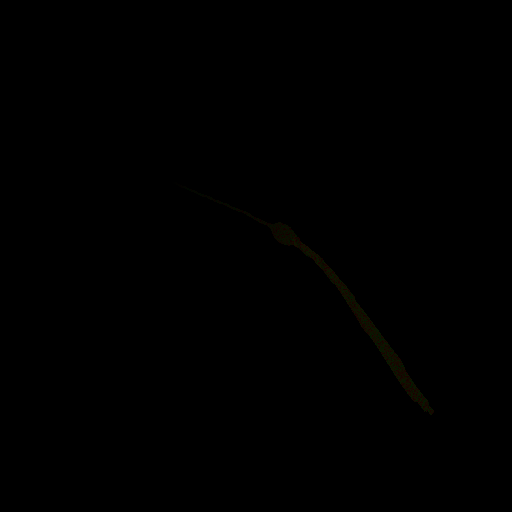

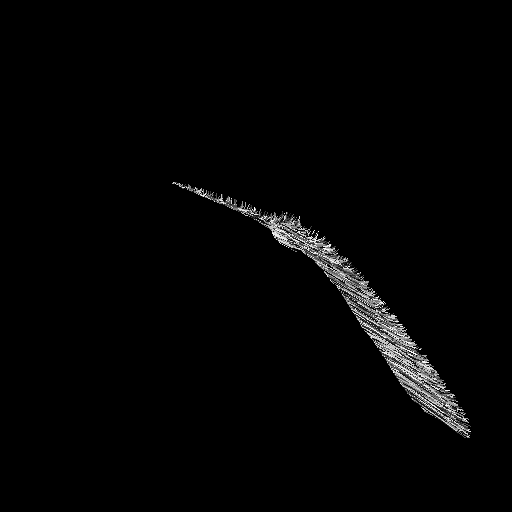

In [13]:
#include <xcpp/xdisplay.hpp>
#include "ScreenSpaceLIC.h"
[=](){
auto try_and_err = [](){






    auto png = convertPng(*canvas);

    displayImage = std::make_unique<im::image>(png);
    xcpp::display(*displayImage);
    
    std::vector<vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 2>>> sl, sr;

    sr.push_back(canvas->pixelPos);
    sl.push_back(canvas->pixelPrePos);
    ScreenSpaceLIC<VectorField< vtkm::Float32,2>, vtkm::Float32> lic(dim);

    auto outArray = lic.draw(sl, sr);
    std::vector<std::uint8_t> png_uflic;
    convertPng(outArray, canvas->GetWidth(), canvas->GetHeight(), png_uflic);
      displayImage = std::make_unique<im::image>(png_uflic);
      xcpp::display(*displayImage);

    
};
try_and_err();
}()